# load packages

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import warnings
from muon import prot as pt
from model.train import train_SMART
from model.utils import fix_seed

fix_seed(2025)

warnings.filterwarnings('ignore')
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/home/ws6tg/anaconda3/envs/EnvR43/lib/R/'

# load data

In [2]:
# read data
file_fold = 'datasets/starmap_ribomap_data/'  #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RIBO.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_STAR.h5ad')


adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

adata_omics1,adata_omics2

(AnnData object with n_obs × n_vars = 58692 × 5413
     obs: 'sample', 'cell_type', 'x', 'y', 'region'
     obsm: 'X_pca_harmony', 'X_umap', 'spatial',
 AnnData object with n_obs × n_vars = 58692 × 5413
     obs: 'sample', 'cell_type', 'x', 'y', 'region'
     obsm: 'X_pca_harmony', 'X_umap', 'spatial')

# data pre-processing

In [3]:
from muon import atac as ac
from model.utils import pca

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)


adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)

# RNA
sc.pp.filter_genes(adata_omics2, min_cells=10)

sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics2, target_sum=1e4)
sc.pp.log1p(adata_omics2)
sc.pp.scale(adata_omics2)


adata_omics2_high = adata_omics2[:, adata_omics2.var['highly_variable']]
adata_omics2.obsm['feat'] = pca(adata_omics2_high, n_comps=30)

# spatial neighbour graph construction

In [4]:
from model.utils import Cal_Spatial_Net

Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=8)
Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=8)

The graph contains 469536 edges, 58692 cells.
8.0000 neighbors per cell on average.
The graph contains 469536 edges, 58692 cells.
8.0000 neighbors per cell on average.


# MNN triplet samples calculation

In [5]:
from model.utils import Mutual_Nearest_Neighbors

anchors1, positives1, negatives1 = Mutual_Nearest_Neighbors(adata_omics1, key="feat", n_nearest_neighbors=3,
                                                            farthest_ratio=0.6)
anchors2, positives2, negatives2 = Mutual_Nearest_Neighbors(adata_omics2, key="feat", n_nearest_neighbors=3,
                                                            farthest_ratio=0.6)

distances calculation completed!
The data use feature 'feat' contains 35980 mnn_anchors
distances calculation completed!
The data use feature 'feat' contains 52470 mnn_anchors


# model training

In [9]:
adata_omics1.obsm["SMART"] = train_SMART(adata_list=[adata_omics1, adata_omics2],
                                       triplet_samples_list=[(anchors1, positives1, negatives1),
                                                             (anchors2, positives2, negatives2)],
                                       feature_key="feat",
                                       edge_key="edgeList",
                                       weights=[1, 1, 1, 1],
                                       emb_dim=64,
                                       n_epochs=150,
                                    weight_decay=1e-4)


100%|█████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:13<00:00, 11.23it/s]


# clustering

In [10]:
from model.utils import clustering
from sklearn.metrics import adjusted_rand_score


tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='SMART', add_key='SMART', n_clusters=11, method=tool, use_pca=True)
ari = adjusted_rand_score(adata_omics1.obs['region'], adata_omics1.obs['SMART'])
print(ari)

fitting ...
  |======================================================================| 100%
0.5744983852440846


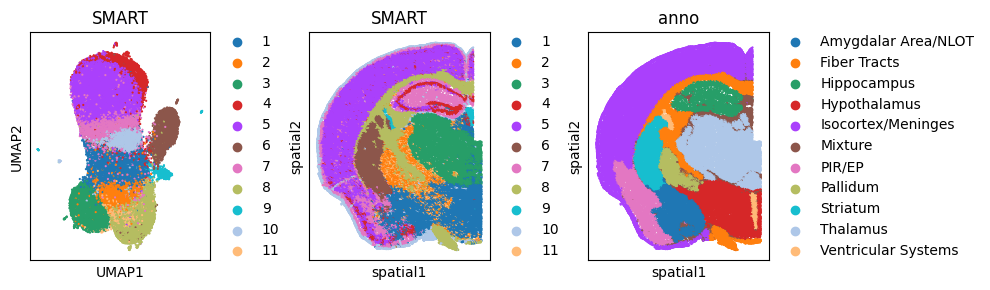

In [11]:
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 3, figsize=(10, 3))
sc.pp.neighbors(adata_omics1, use_rep='SMART', n_neighbors=10)
sc.tl.umap(adata_omics1)

sc.pl.umap(adata_omics1, color='SMART', ax=ax_list[0], title='SMART', s=10, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='SMART', ax=ax_list[1], title='SMART', s=10, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='region', ax=ax_list[2], title='anno', s=10, show=False)
plt.tight_layout(w_pad=0.3)
plt.show()

# downsampling

In [20]:
from model.train import train_SMART_2m
import random

#downsampling_rate
ds_rate = 0.2
idx = random.sample(adata_omics1.obs_names.tolist(), int(ds_rate * len(adata_omics1)))
adata_omics1_d = adata_omics1[idx].copy()
adata_omics2_d = adata_omics2[idx].copy()

Cal_Spatial_Net(adata_omics1_d, model="KNN", n_neighbors=8)
Cal_Spatial_Net(adata_omics2_d, model="KNN", n_neighbors=8)

anchors1, positives1, negatives1 = Mutual_Nearest_Neighbors(adata_omics1_d, key='feat', n_nearest_neighbors=3,
                                                            farthest_ratio=0.4)
anchors2, positives2, negatives2 = Mutual_Nearest_Neighbors(adata_omics2_d, key='feat', n_nearest_neighbors=3,
                                                            farthest_ratio=0.4)

x1, e1, x2, e2 = (torch.FloatTensor(adata_omics1_d.obsm["feat"]).to(device), 
                torch.LongTensor(adata_omics1_d.uns["edgeList"]).to(device), 
                torch.FloatTensor(adata_omics2_d.obsm["feat"]).to(device),
                torch.LongTensor(adata_omics2_d.uns["edgeList"]).to(device))

#training with downsampling data
model = train_SMART_2m(feature=[x1, x2],
                       triplet_samples_list=[(anchors1, positives1, negatives1),
                                             (anchors2, positives2, negatives2)],
                       edge=[e1, e2],
                       weights=[1, 1, 1, 1],
                       n_epochs=150,
                       emb_dim=64,
                       weight_decay=1e-4
                       )

z1 = model(x1, e1, x2, e2)[0]
adata_omics1_d.obsm[f"SMART"] = z1.to('cpu').detach().numpy()

tool = 'mclust' 
clustering(adata_omics1_d, key=f"SMART", add_key=f"SMART", n_clusters=11, method=tool, use_pca=True)
ari = adjusted_rand_score(adata_omics1_d.obs['region'], adata_omics1_d.obs[f"SMART"])

The graph contains 93904 edges, 11738 cells.
8.0000 neighbors per cell on average.
The graph contains 93904 edges, 11738 cells.
8.0000 neighbors per cell on average.
distances calculation completed!
The data use feature 'feat' contains 7710 mnn_anchors
distances calculation completed!
The data use feature 'feat' contains 9690 mnn_anchors


100%|█████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.95it/s]


fitting ...
  |======================================================================| 100%


In [ ]:

#validate in original data
Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=8)
Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=8)

x1_a, e1_a, x2_a, e2_a = (torch.FloatTensor(adata_omics1.obsm["feat"]).to(device), 
                          torch.LongTensor(adata_omics1.uns["edgeList"]).to(device), 
                          torch.FloatTensor(adata_omics2.obsm["feat"]).to(device), 
                          torch.LongTensor(adata_omics2.uns["edgeList"]).to(device))

z2 = model(x1_a, e1_a, x2_a, e2_a)[0]
adata_omics1.obsm[f"SMART"] = z2.to('cpu').detach().numpy()

clustering(adata_omics1, key=f"SMART", add_key=f"SMART", n_clusters=11, method=tool, use_pca=True)
ari1 = adjusted_rand_score(adata_omics1.obs['region'], adata_omics1.obs[f"SMART"])

The graph contains 469536 edges, 58692 cells.
8.0000 neighbors per cell on average.
The graph contains 469536 edges, 58692 cells.
8.0000 neighbors per cell on average.
fitting ...
  |======================================================================| 100%


In [ ]:
fig, ax_list = plt.subplots(1, 2, figsize=(5, 3),dpi=200)

sc.pl.embedding(adata_omics1_d, basis='spatial', color='SMART', ax=ax_list[0], title=f'ari={ari:.3f}', s=5, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='SMART', ax=ax_list[1], title=f'ari={ari1:.3f}', s=2, show=False)

ax_list[0].set_xlabel("")
ax_list[0].set_ylabel(f"Down sampling rate : {ds_rate}")
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].get_legend().remove()

plt.tight_layout(w_pad=0.2)
plt.show()